## IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sb

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## DATASET INPUT

In [ ]:
stocks=input("Enter the code of the stock:-")
df=yf.download(stocks,"2008-01-01","2025-04-04",auto_adjust=True) ##this is done for gold here , GC=F is the code and the code ahead is for it only
df.head()


Enter the code of the stock:- TSLA


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [ ]:
df.shape

(3715, 5)

## Exploratory Data Analysis

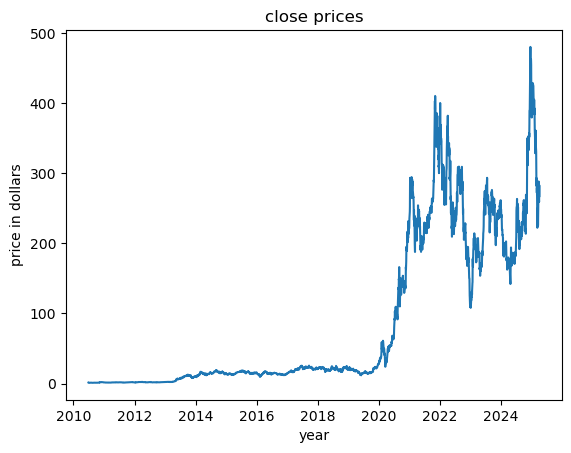

In [ ]:
plt.plot(df["Close"])
plt.title("close prices")
plt.xlabel("year")
plt.ylabel("price in dollars")
plt.show()

## CHECKING NULL VALUES


In [ ]:
df.isnull().sum()

Price       Ticker
Close       TSLA      0
High        TSLA      0
Low         TSLA      0
Open        TSLA      0
Volume      TSLA      0
open-close            0
low-high              0
target                0
dtype: int64

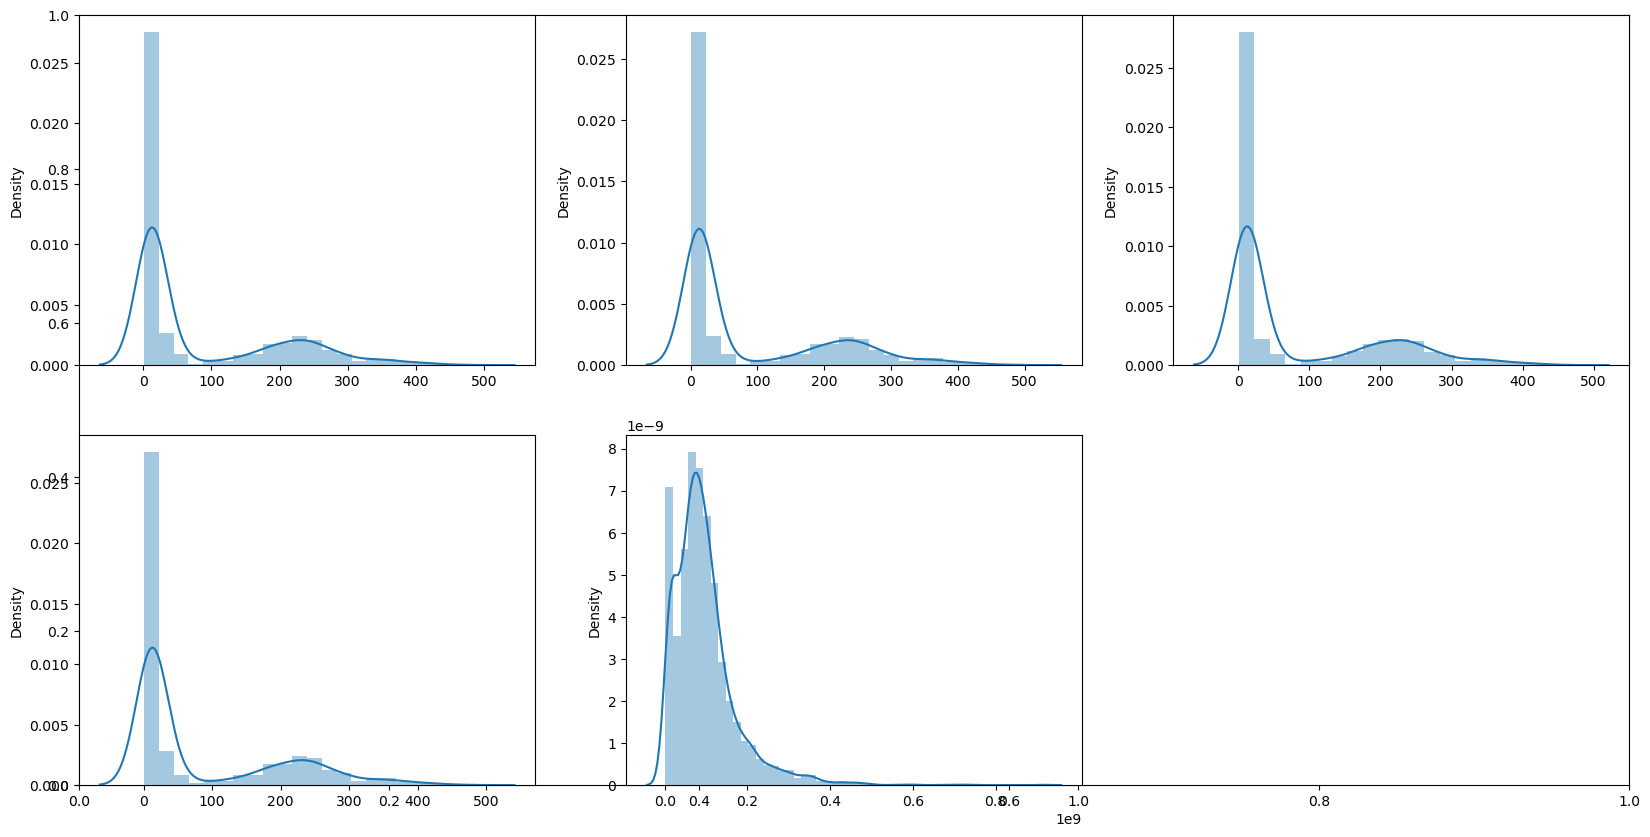

In [ ]:
cols=["Close","High","Low","Open","Volume"]

plt.subplots(figsize=(20,10))

for i, col in enumerate(cols):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()


## CHECKING FOR OUTLIERS

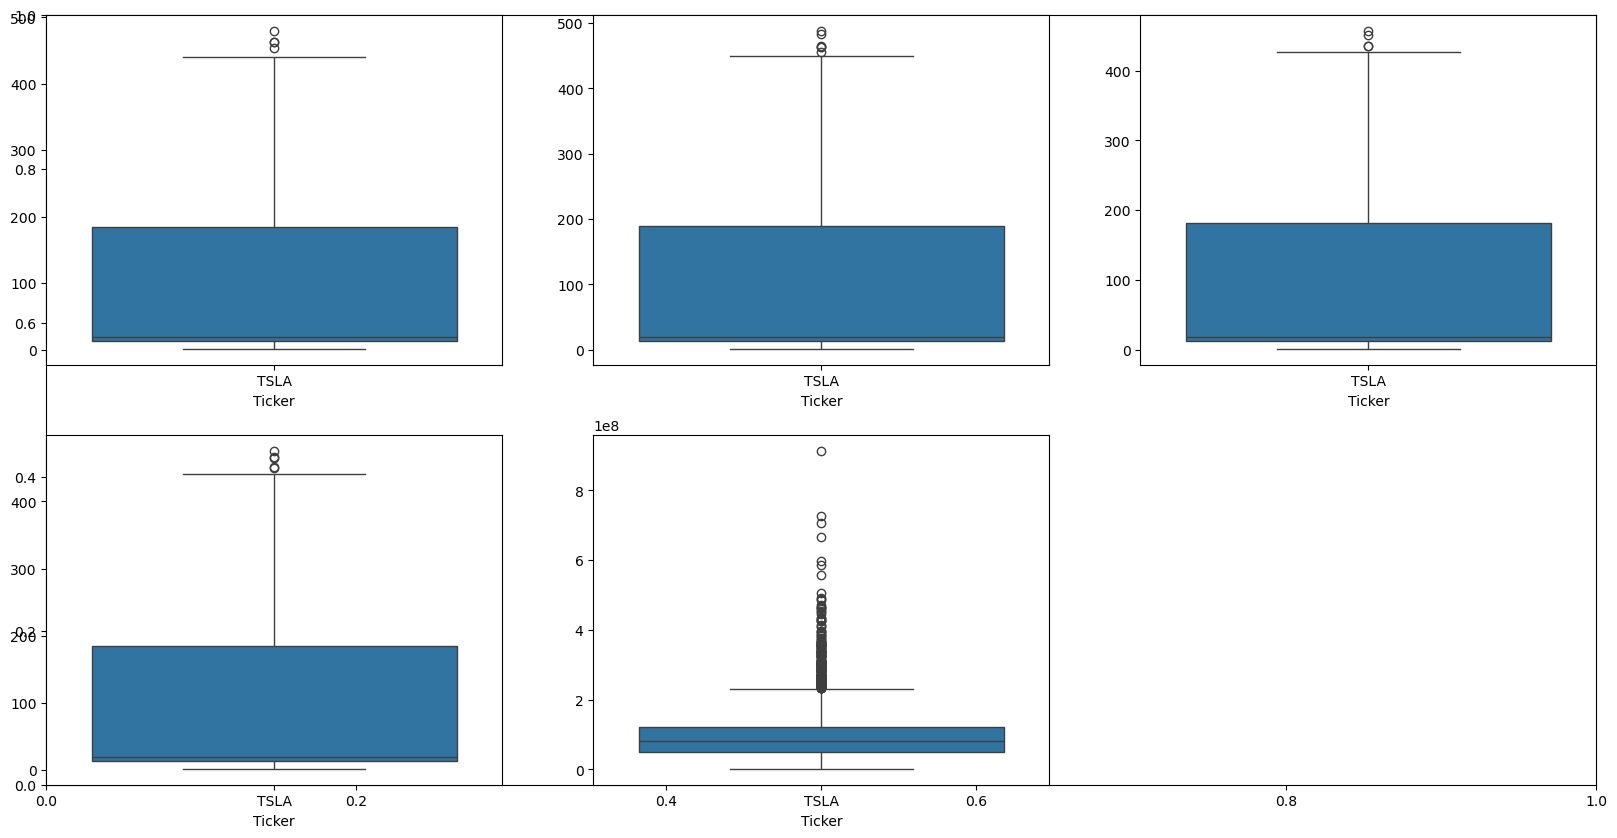

In [ ]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(cols):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

## REMOVING OUTLIERS

In [ ]:
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

In [ ]:
df_cleaned = remove_outliers_iqr(df, cols)

In [ ]:
print("After removing outliers:", df_cleaned.shape)

After removing outliers: (3715, 5)


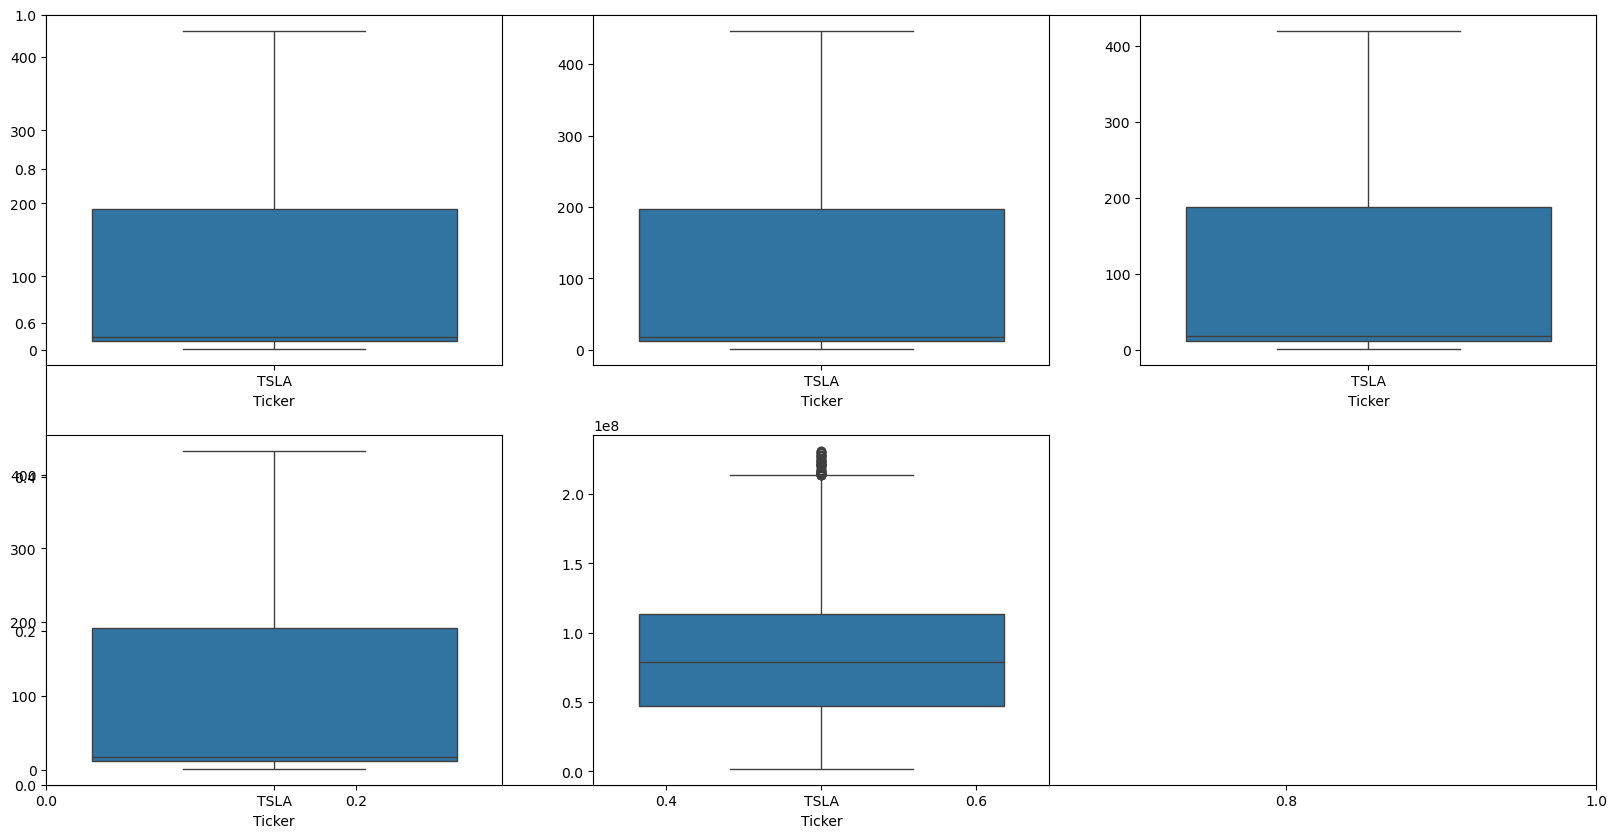

In [ ]:
plt.subplots(figsize=(20,10))
for i,c in enumerate(cols):
    plt.subplot(2,3,i+1)
    sns.boxplot(df_cleaned[c])


In [ ]:
df.columns

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])

## CREATING TARGET AND CHECKING IF IT'S BALANCED
We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

In [ ]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)


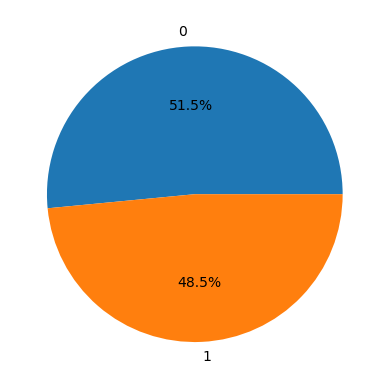

In [ ]:
plt.pie(df['target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()


## CHECKING CORRELATION AMONG FEATURES

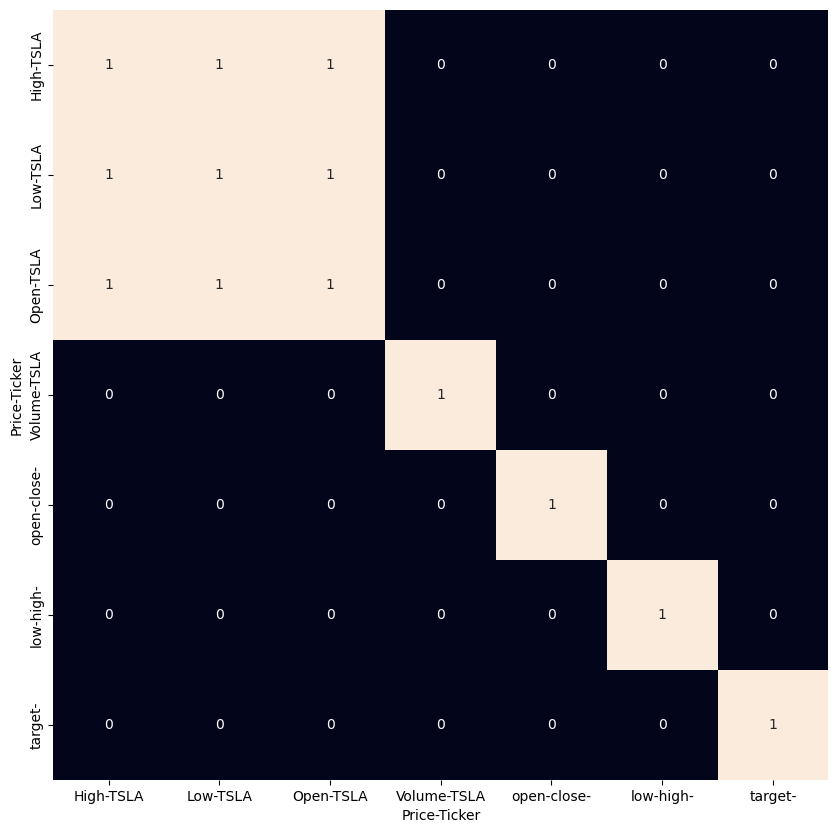

In [ ]:
plt.figure(figsize=(10, 10)) 

# As our concern is with the highly 
# correlated features only so, we will visualize 
# our heatmap as per that criteria only. 
sb.heatmap(df.drop('Close', axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

## DATA SPLITTING

In [ ]:
features = df[['open-close', 'low-high']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)


(3343, 2) (372, 2)


## MODEL TRAINING

In [ ]:
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()


LogisticRegression() : 
Training Accuracy :  0.5178166208663217
Validation Accuracy :  0.4559227455402319

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4988037437302266
Validation Accuracy :  0.45369647555439907

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Train

## CONFUSION MATRIX

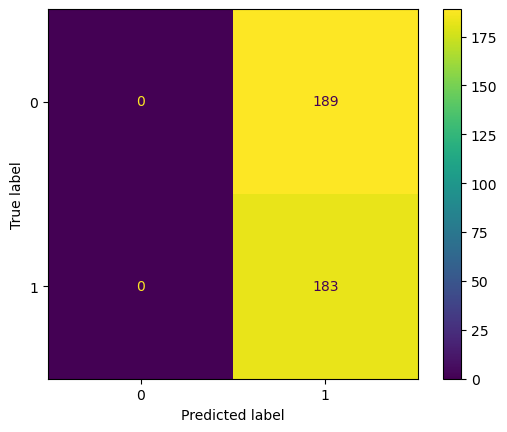

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()
